In [16]:
%matplotlib inline

# Day 0019 - 
# - 1000 days of Python 

# Setup working directory

In [25]:
pwd

'D:\\OneDrive - Curtin University of Technology Australia\\write\\c3_vU\\Observed_Tide\\All_Merged_Tide'

In [2]:
cd D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide

D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide


In [3]:
pwd

'D:\\OneDrive - Curtin University of Technology Australia\\write\\c3_vU\\Observed_Tide\\All_Merged_Tide'

# Import Libraries

In [4]:
import glob
import os
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpl_dates
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

# Create a functions

In [5]:
#list all file with extentions
def nameList_F_withExt(InputFolder,filterString="*"):
	'''
	pathList_F_ext(InputFolder,filterString="*")
	list all files and folders in InputFolder
	return a list of names for every file and folder matching folderString
	file includes extention (ext) information
	'''	
	
	import glob	

	os.chdir(InputFolder) #change working folder
	return glob.glob(filterString)

In [6]:
def kmlTemplate():
    return """<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>%s</name>
	<StyleMap id="m_ylw-pushpin">
		<Pair>
			<key>normal</key>
			<styleUrl>#s_ylw-pushpin</styleUrl>
		</Pair>
		<Pair>
			<key>highlight</key>
			<styleUrl>#s_ylw-pushpin_hl</styleUrl>
		</Pair>
	</StyleMap>
	<Style id="s_ylw-pushpin">
		<IconStyle>
			<scale>1.2</scale>
			<Icon>
				<href>http://maps.google.com/mapfiles/kml/shapes/water.png</href>
			</Icon>
			<hotSpot x="0.5" y="0" xunits="fraction" yunits="fraction"/>
		</IconStyle>
		<ListStyle>
		</ListStyle>
	</Style>
	<Style id="s_ylw-pushpin_hl">
		<IconStyle>
			<scale>1.4</scale>
			<Icon>
				<href>http://maps.google.com/mapfiles/kml/shapes/water.png</href>
			</Icon>
			<hotSpot x="0.5" y="0" xunits="fraction" yunits="fraction"/>
		</IconStyle>
		<ListStyle>
		</ListStyle>
	</Style>
	<Placemark>
		<name>%s</name>
		<description><![CDATA[<img " src="file:///%s"/>]]></description>
		<styleUrl>#m_ylw-pushpin</styleUrl>
		<Point>
			<gx:drawOrder>1</gx:drawOrder>
			<coordinates>%s,%s,0</coordinates>
		</Point>
	</Placemark>
</Document>
</kml>"""

In [7]:
#% Plotting function
def du_s_f_gauge(dtime_gauge,msg):
    """
    Parameters
    dtime_gauge : 
        TYPE list
        DESCRIPTION: datetime data of the gauge

    Do:
        print out duration of the gauge
        start and end time of the gauge

    Returns
        None.

    """
        
    print(f'{msg}: {max(dtime_gauge) - min(dtime_gauge)}')
    print('Start:',min(dtime_gauge))
    print('End:',max(dtime_gauge))
    

In [8]:
##############################################################################
#% import tide data function
def import_tide_data(flist):
    #a list to hold tide data
    TG = []
    #a list to hold time
    dtime = []
    #for each index and obs
    for idx,obsfile in enumerate(flist):
        # obsfile = flist[0]
        try:
            with open(obsfile,'r') as fp:
                content = fp.readlines()
                hdr = content[:1]
                data = content
                # for idx_sub,item in enumerate(hdr):
                #     key = (item.split(":")[0]).strip()
                #     value = (item.split(":")[1]).strip()               
                #     gauge_info[key]=value
                #     print(f'{key}: {gauge_info[key]}')            
            fp.close()
            
            for line in data:
                # line = data[1]kk
                try:
                    words = line.split()
                    wl_tmp = words[2]
                    wl_tmp = wl_tmp[:-1]
                    if not wl_tmp:
                        wl_tmp = 0                  
                    else:
                        wl_tmp = float(wl_tmp)   
                    TG.append(wl_tmp)
                    
                    datetime_tmp = words[0]+','+words[1][:-4]
                    datetime_local = datetime.strptime(datetime_tmp,"%Y/%m/%d,%H:%M:%S")
                    #set local time to where you analyse the TG
                    #auto detection time_delta
                    UL_delta = datetime.utcnow()-datetime.now() 
                    #set the offset manually, WA to UTC is -8 hours
                    UL_delta = timedelta(seconds=-8*60*60)
                    #if time was already UTC, just set to 0 hour
                    UL_delta = timedelta(seconds=0)
                    datetime_utc =  datetime_local + UL_delta
                    dtime.append(datetime_utc)
                except:
                    print("-------Warning! Blank line or wrong format. See line below...-------")
                    print(line)
                    print("-------end of empty or erroneous line-------")            
        except IOError:
            print("Could not open %s. Observations record will be incomplete." % obsfile)        
    return dtime,TG
    print("*******All the data has been read in!*******")

In [10]:
#can be better but work for now
def newFolderF(MotherDir,Dir2Create = 'newDir'):
	'''
	
	'''
	outDir_path = os.path.join(MotherDir,Dir2Create)
	if not os.path.isdir(outDir_path): os.makedirs(outDir_path)
	elif os.path.isdir(outDir_path): 
		pass
		print('Already existed',outDir_path)
	else: print('xbug report: something wrong')
	return outDir_path

In [11]:
def DegMin2DecimalDeg(in_deg,in_min):
    return in_deg + in_min/60

In [12]:
def tide_interploate(in_dt,in_tide,dt_YmdHMS):
    # dt_fm = "%Y/%m/%d %H:%M:%S"
    dt_fm = "%Y-%m-%d %H:%M:%S"
    dt_np = np.array(in_dt)
    tide_np = np.array(in_tide)
    dt_tide_df = pd.DataFrame({'dt':dt_np,
                               'tide':tide_np})
    inter_dtobj = datetime.strptime(dt_YmdHMS, dt_fm)
    #add datetime item into dataframe
    dt_tide_df = dt_tide_df.append(
                                {dt_tide_df.columns[0] : inter_dtobj,
                                 dt_tide_df.columns[1] : ''},
                                 ignore_index=True)
    dt_tide_df.set_index('dt')
    dt_tide_df.sort_index(ascending=True,inplace=True)
    dt_tide_df.interpolate(method ='linear',inplace=True)
    out_inter_tide = dt_tide_df.loc[dt_tide_df['dt'] == inter_dtobj]['tide']
    return out_inter_tide.iloc[0]

# in_dt = dtime_Observed_LWMF_UTC
# in_tide = tide_Observed_LWMF_UTC
# dt_YmdHMS = missing_datetime
# tide_interploate(in_dt,in_tide,dt_YmdHMS)

In [13]:
#%%
pythonFile_dir = r'D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide'
export_result_folder = r'D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide'
pydir = pythonFile_dir

#create a folder named backup and a subfolder named year-mon-day-h-m
from datetime import datetime as dt
obsdir = r'D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide'
newFolderF(obsdir,'Tide_Plot')
dt_now = dt.now()
dt_format1 = "%Y%m%d"
dt_now_str = dt_now.strftime(dt_format1)
result_day = newFolderF(os.path.join(obsdir,'Tide_Plot'),dt_now_str)

Already existed D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot
Already existed D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115


In [14]:
#%% Make a function to read tide data
#read _Observed_LWMF_UTC.tid"

datetimeformat1 = "%Y/%m/%d %H:%M:%S"
datetimeformat2 = "%Y-%m-%d %H:%M:%S"

gauge_info = {} #gauge_info dic
gauge_info['Site']='Tide Data'
gauge_info['Longitude'] = DegMin2DecimalDeg(130,45.36705)
gauge_info['Latitude'] = -DegMin2DecimalDeg(12,12.05189)
dtime_Observed_LWMF_UTC = []
tide_Observed_LWMF_UTC = []
  
#read .tid files
flist = nameList_F_withExt(obsdir,"Observed_LWMF_UTC.tid")
dtime_Observed_LWMF_UTC,tide_Observed_LWMF_UTC = import_tide_data(flist)
du_s_f_gauge(dtime_Observed_LWMF_UTC,'dtime_Observed_LWMF_UTC')

-------Warning! Blank line or wrong format. See line below...-------
--------

-------end of empty or erroneous line-------
dtime_Observed_LWMF_UTC: 2136 days, 2:23:01
Start: 2014-09-30 16:00:00
End: 2020-08-05 18:23:01


In [15]:
################################
#%%
#read _Predicted_LWMF_UTC Tide
gauge_info = {} #gauge_info dic
gauge_info['Site']='Tide Data'
gauge_info['Longitude'] = DegMin2DecimalDeg(130,44.17480)
gauge_info['Latitude'] = -DegMin2DecimalDeg(11,59.64350)
dtime_Predicted_LWMF_UTC = []
tide_Predicted_LWMF_UTC = []
#read .tid files
flist = nameList_F_withExt(obsdir,"Predicted_LWMF_UTC.tid")
dtime_Predicted_LWMF_UTC,tide_Predicted_LWMF_UTC = import_tide_data(flist)
du_s_f_gauge(dtime_Predicted_LWMF_UTC,'dtime_Predicted_LWMF_UTC')

-------Warning! Blank line or wrong format. See line below...-------
--------

-------end of empty or erroneous line-------
dtime_Predicted_LWMF_UTC: 2921 days, 23:50:00
Start: 2013-01-01 00:10:00
End: 2021-01-01 00:00:00


2012-12-31 00:10:00
2021-01-02 00:00:00


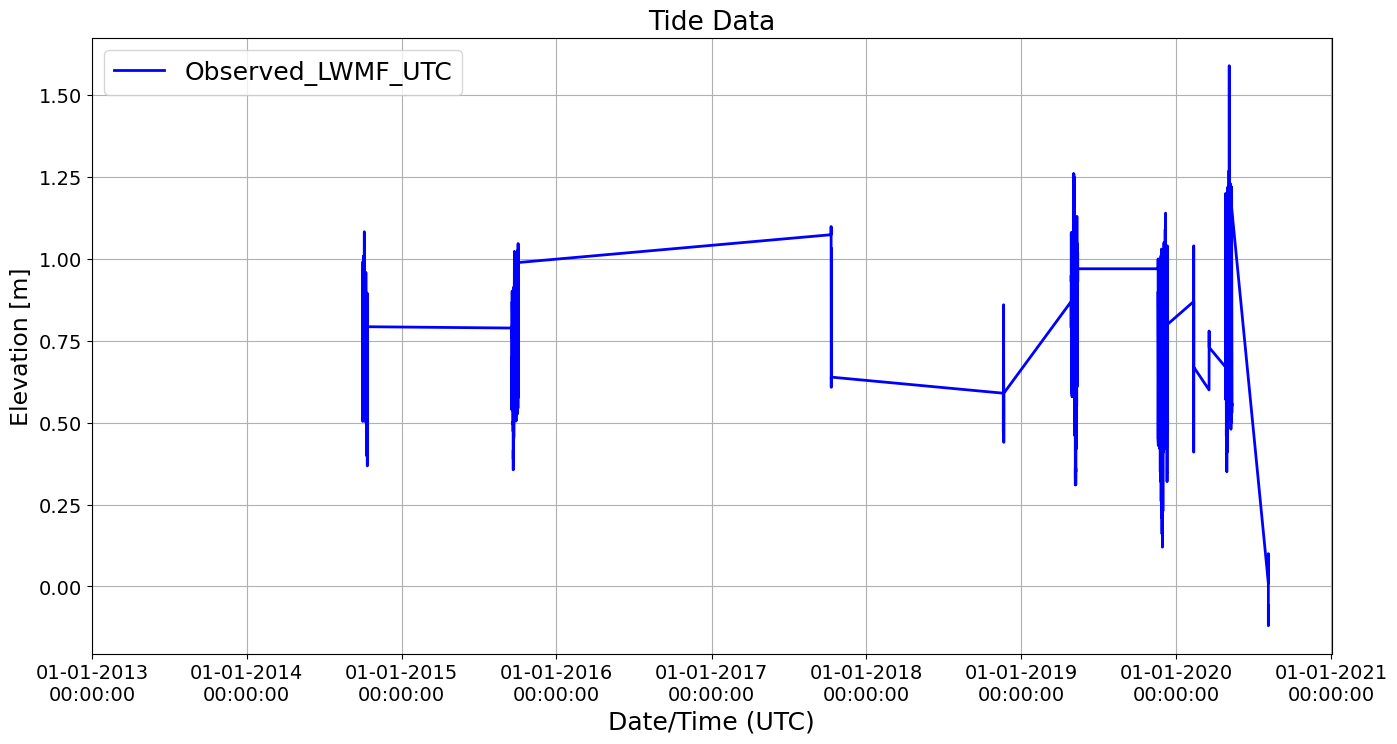

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Figs\Tide Data_2012-12-31_2021-01-02.png


In [16]:
#%% Plot Everything:
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    cut_fromStart_obj = timedelta(days=0,hours=0,minutes=0)
    cut_fromEnd_obj = timedelta(days=0,hours=0,minutes=0)
    plot_gap_obj = timedelta(days=1,hours=0,minutes=0)
    
    start_plot = start_time+cut_fromStart_obj-plot_gap_obj
    end_plot = end_time-cut_fromEnd_obj+plot_gap_obj
    
    print(start_plot)
    print(end_plot)
    
    s_time_str = (start_plot).strftime(datetimeformat2) 
    e_time_str = (end_plot).strftime(datetimeformat2) 
    
    kwargs = {
        # "start":"2021/03/10 02:37:00", # "%Y/%m/%d %H:%M:%S"
        # "end":"2021/04/5 07:20:00",
        "start":s_time_str, # "%Y-%m-%d %H:%M:%S"
        "end":e_time_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        # "waterlevel_Predicted_LWMF_UTC":"r-",
        # "waterlevel_Predicted_LWMF_UTC":"c-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True
        }
    
    #plot decorations
    x_s,y_s = 16,8
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    
    
    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    fig = plt.figure(figsize=(x_s,y_s))
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    
    
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border    
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    plt.show()
    
    
    #%
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(pythonFile_dir,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(pythonFile_dir,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")

if __name__ == "__main__":
    main()

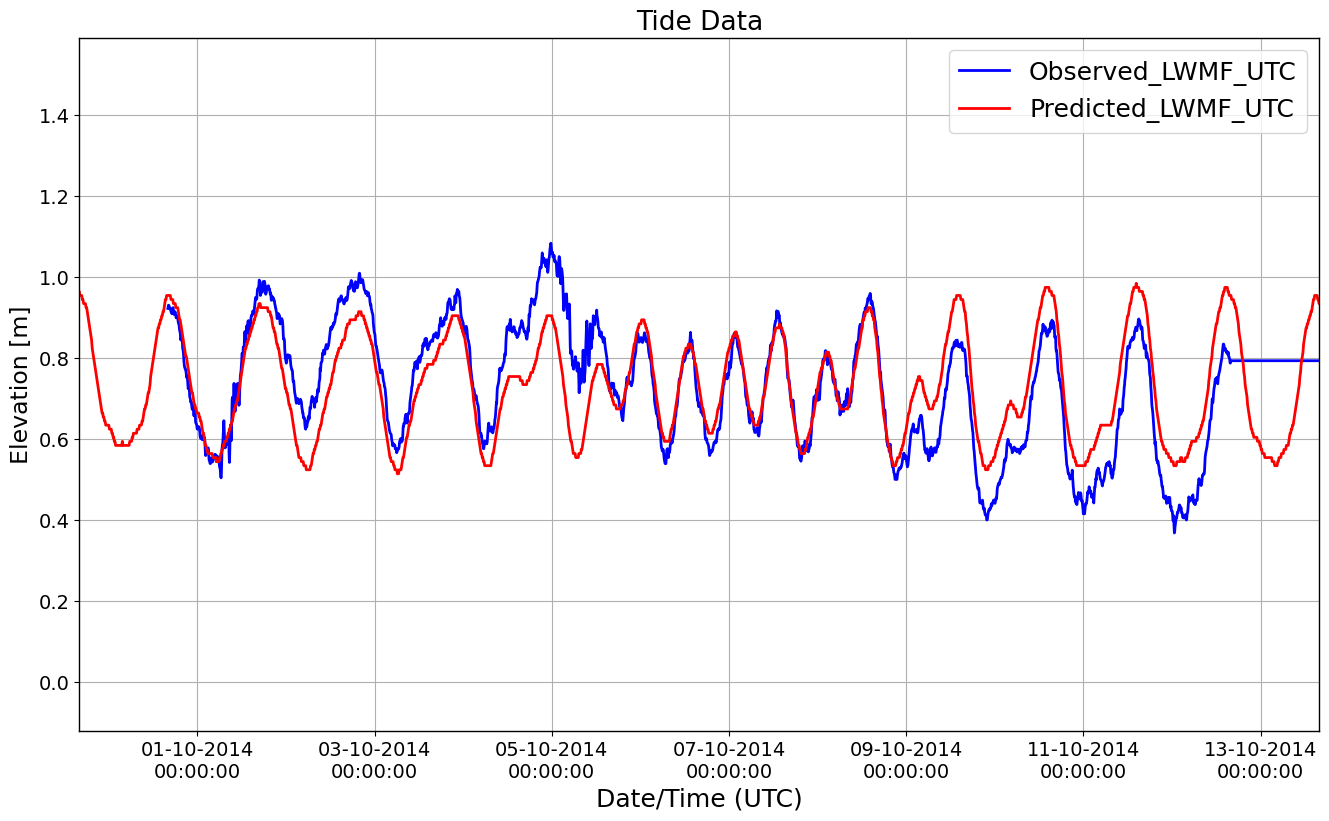

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115\Figs\Tide Data_2014-09-29_2014-10-13.png


In [17]:
#%% Custom plot
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    #define step using time delta object
    # datetime.timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
    fromStart_obj = timedelta(days=0,hours=0)
    fromEnd_obj = timedelta(days=1,hours=0)
    plot_period_obj = timedelta(days=10,hours=0)
    plot_gap_obj = timedelta(days=0,hours=5,minutes=0)
    s_time_sub_obj = start_time + fromStart_obj -plot_gap_obj
    e_time_sub_obj = s_time_sub_obj + plot_period_obj + plot_gap_obj
    m_time_sub_obj = s_time_sub_obj + (e_time_sub_obj - s_time_sub_obj)/2


    # s_time_sub_str = s_time_sub_obj.strftime(datetimeformat2)
    # e_time_sub_str = e_time_sub_obj.strftime(datetimeformat2)
    # m_time_sub_str = m_time_sub_obj.strftime(datetimeformat2)
    s_time_sub_str = "2014-09-29 16:00:00" #"%Y-%m-%d %H:%M:%S"
    e_time_sub_str = "2014-10-13 15:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2015-09-17 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2015-10-03 0:59:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2017-10-09 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2017-10-12 00:00:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2018-11-19 00:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2018-11-22 00:05:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-04-28 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-05-15 0:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-11-19 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-12-12 0:55:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2020-02-11 0:34:18" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-02-12 0:42:20" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-03-17 23:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-03-20 01:45:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-04-25 16:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-12 15:55:00" #"%Y-%m-%d %H:%M:%S"
    # 
    # s_time_sub_str = "2020-05-9 20:30:20" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-11 20:47:17" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-08-04 17:48:05" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-08-06 18:23:01" #"%Y-%m-%d %H:%M:%S"
    # m_time_sub_str = "2021-04-04 0:0:0"
    
    kwargs = {
        "start":s_time_sub_str,
        "end":e_time_sub_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        "waterlevel_Predicted_LWMF_UTC":"r-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True,
        
        }
    
    #plot decorations
    x_s,y_s = 16,9
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    fig = plt.figure(figsize=(x_s,y_s))
    

    x_lim_adjust_above = 0.0
    x_lim_adjust_below = 0.0
    

    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    

    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    
   
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    
    # start_plot = very_start
    # end_plot = very_end
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    
    # ax1.set_ylim([1.0,2.15]) set y lime based on max and min tide
    Max_tide = max(max(tide_Observed_LWMF_UTC),max(tide_Predicted_LWMF_UTC))
    Min_tide = min(min(tide_Observed_LWMF_UTC),min(tide_Predicted_LWMF_UTC))
    
    ax1.set_ylim([Min_tide+x_lim_adjust_below,Max_tide-x_lim_adjust_above])
    
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    aspect_vl = 'auto'
    # aspect_vl = 'equal'
    # aspect_vl = '0.1'
    ax1.set_aspect(aspect_vl)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    
    #Plot tide value for one spot
    
    # in_dt_str = m_time_sub_str
    # in_dt_str = min(dtime_SI1016_TG1B_LAT).strftime(datetimeformat2)
    # in_result = tide_interploate(in_dt=dtime_Predicted_LWMF_UTC,
    #                  in_tide=tide_Predicted_LWMF_UTC,
    #                  dt_YmdHMS=in_dt_str)
    # msg = f'Interpolated result for SI1016_TG1 is: {in_result} m'
    # print(msg)


    # # draw a vertical line at the check point 2do
    # plt.axvline(x=max(dtime_Observed_LWMF_UTC),
    #             color="b", 
    #             linestyle="-",
    #             linewidth=2.0)
    
    # plt.scatter(max(dtime_Observed_LWMF_UTC),tide_Observed_LWMF_UTC[-1])
    # plt.text(max(dtime_Observed_LWMF_UTC), tide_Observed_LWMF_UTC[-1], tide_Observed_LWMF_UTC[-1],
    #           fontsize=14,color='b')
    # #Plot a vertical line where interpolation take place

    plt.show()
    
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(result_day,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(result_day,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")
    

if __name__ == "__main__":
    main()

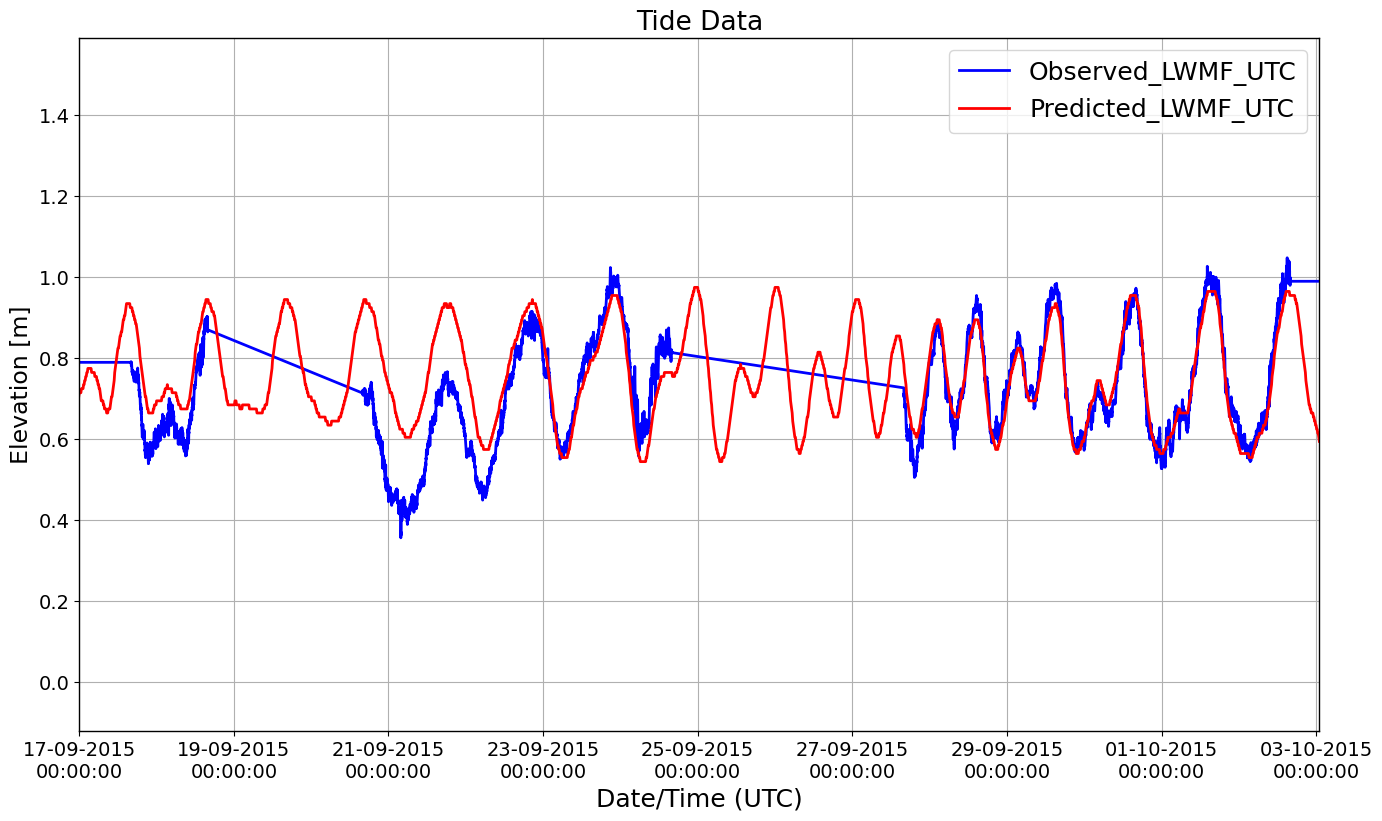

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115\Figs\Tide Data_2015-09-17_2015-10-03.png


In [18]:
#%% Custom plot
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    #define step using time delta object
    # datetime.timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
    fromStart_obj = timedelta(days=0,hours=0)
    fromEnd_obj = timedelta(days=1,hours=0)
    plot_period_obj = timedelta(days=10,hours=0)
    plot_gap_obj = timedelta(days=0,hours=5,minutes=0)
    s_time_sub_obj = start_time + fromStart_obj -plot_gap_obj
    e_time_sub_obj = s_time_sub_obj + plot_period_obj + plot_gap_obj
    m_time_sub_obj = s_time_sub_obj + (e_time_sub_obj - s_time_sub_obj)/2


    # s_time_sub_str = s_time_sub_obj.strftime(datetimeformat2)
    # e_time_sub_str = e_time_sub_obj.strftime(datetimeformat2)
    # m_time_sub_str = m_time_sub_obj.strftime(datetimeformat2)
    
#     s_time_sub_str = "2014-09-29 16:00:00" #"%Y-%m-%d %H:%M:%S"
#     e_time_sub_str = "2014-10-13 15:55:00" #"%Y-%m-%d %H:%M:%S"
    
    s_time_sub_str = "2015-09-17 0:00:00" #"%Y-%m-%d %H:%M:%S"
    e_time_sub_str = "2015-10-03 0:59:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2017-10-09 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2017-10-12 00:00:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2018-11-19 00:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2018-11-22 00:05:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-04-28 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-05-15 0:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-11-19 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-12-12 0:55:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2020-02-11 0:34:18" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-02-12 0:42:20" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-03-17 23:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-03-20 01:45:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-04-25 16:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-12 15:55:00" #"%Y-%m-%d %H:%M:%S"
    # 
    # s_time_sub_str = "2020-05-9 20:30:20" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-11 20:47:17" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-08-04 17:48:05" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-08-06 18:23:01" #"%Y-%m-%d %H:%M:%S"
    # m_time_sub_str = "2021-04-04 0:0:0"
    
    kwargs = {
        "start":s_time_sub_str,
        "end":e_time_sub_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        "waterlevel_Predicted_LWMF_UTC":"r-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True,
        
        }
    
    #plot decorations
    x_s,y_s = 16,9
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    fig = plt.figure(figsize=(x_s,y_s))
    

    x_lim_adjust_above = 0.0
    x_lim_adjust_below = 0.0
    

    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    

    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    
   
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    
    # start_plot = very_start
    # end_plot = very_end
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    
    # ax1.set_ylim([1.0,2.15]) set y lime based on max and min tide
    Max_tide = max(max(tide_Observed_LWMF_UTC),max(tide_Predicted_LWMF_UTC))
    Min_tide = min(min(tide_Observed_LWMF_UTC),min(tide_Predicted_LWMF_UTC))
    
    ax1.set_ylim([Min_tide+x_lim_adjust_below,Max_tide-x_lim_adjust_above])
    
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    aspect_vl = 'auto'
    # aspect_vl = 'equal'
    # aspect_vl = '0.1'
    ax1.set_aspect(aspect_vl)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    
    #Plot tide value for one spot
    
    # in_dt_str = m_time_sub_str
    # in_dt_str = min(dtime_SI1016_TG1B_LAT).strftime(datetimeformat2)
    # in_result = tide_interploate(in_dt=dtime_Predicted_LWMF_UTC,
    #                  in_tide=tide_Predicted_LWMF_UTC,
    #                  dt_YmdHMS=in_dt_str)
    # msg = f'Interpolated result for SI1016_TG1 is: {in_result} m'
    # print(msg)


    # # draw a vertical line at the check point 2do
    # plt.axvline(x=max(dtime_Observed_LWMF_UTC),
    #             color="b", 
    #             linestyle="-",
    #             linewidth=2.0)
    
    # plt.scatter(max(dtime_Observed_LWMF_UTC),tide_Observed_LWMF_UTC[-1])
    # plt.text(max(dtime_Observed_LWMF_UTC), tide_Observed_LWMF_UTC[-1], tide_Observed_LWMF_UTC[-1],
    #           fontsize=14,color='b')
    # #Plot a vertical line where interpolation take place

    plt.show()
    
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(result_day,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(result_day,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")
    

if __name__ == "__main__":
    main()

# All in one scripts

## Functions

In [19]:
import glob
import os
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpl_dates
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np


#%% 



#list all file with extentions
def nameList_F_withExt(InputFolder,filterString="*"):
	'''
	pathList_F_ext(InputFolder,filterString="*")
	list all files and folders in InputFolder
	return a list of names for every file and folder matching folderString
	file includes extention (ext) information
	'''	
	
	import glob	

	os.chdir(InputFolder) #change working folder
	return glob.glob(filterString)

# def cleanString(instring):
#     lchar = (instring[-1])
#     if lchar.isdigit():
#         cleanstring = instring
#     elif lchar=="N":
#         cleanstring = ""
#     else:
#         cleanstring = instring[:-1]
#     return cleanstring

# cleanString('126')

# def getPks(ss,ff):        
#     pks = []
#     pksdatetime = []
#     respks = []
#     pkidx = waterlevel_predicted[ss:ff].index(max(waterlevel_predicted[ss:ff]))       
#     pkwl = waterlevel_predicted[ss:ff][pkidx]
#     pktime = dtime_predicted[ss:ff][pkidx]
#     pkres = residual[ss:ff][pkidx]        
#     for i in range(1,len(waterlevel_predicted[ss:ff])-1):
#         if waterlevel_predicted[ss:ff][i] and waterlevel_predicted[ss:ff][i-1] and waterlevel_predicted[ss:ff][i+1]:
#             if waterlevel_predicted[ss:ff][i]>=waterlevel_predicted[ss:ff][i-1] and waterlevel_predicted[ss:ff][i]>waterlevel_predicted[ss:ff][i+1]:
#                 pks.append(waterlevel_predicted[ss:ff][i])
#                 respks.append(residual[ss:ff][i])
#                 pksdatetime.append(dtime_predicted[ss:ff][i])
#     #remove any potential double spikes
#     doublePks = True
#     while doublePks:
#         print("Cleaning none HWs and double peaks...")
#         test = False
#         for i in range(1,len(pks)):
#             if (pksdatetime[i]-pksdatetime[i-1]).total_seconds()<(10.*3600.):  
#                 if pks[i]>pks[i-1]:
#                     del pksdatetime[i-1]
#                     del pks[i-1]
#                     del respks[i-1]
#                 else:
#                     del pksdatetime[i]
#                     del pks[i]
#                     del respks[i]
#                 test = True
#                 break
#         if not test:
#             doublePks = False
#     return pks,pksdatetime,respks
##%%
##%%
def kmlTemplate():
    return """<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>%s</name>
	<StyleMap id="m_ylw-pushpin">
		<Pair>
			<key>normal</key>
			<styleUrl>#s_ylw-pushpin</styleUrl>
		</Pair>
		<Pair>
			<key>highlight</key>
			<styleUrl>#s_ylw-pushpin_hl</styleUrl>
		</Pair>
	</StyleMap>
	<Style id="s_ylw-pushpin">
		<IconStyle>
			<scale>1.2</scale>
			<Icon>
				<href>http://maps.google.com/mapfiles/kml/shapes/water.png</href>
			</Icon>
			<hotSpot x="0.5" y="0" xunits="fraction" yunits="fraction"/>
		</IconStyle>
		<ListStyle>
		</ListStyle>
	</Style>
	<Style id="s_ylw-pushpin_hl">
		<IconStyle>
			<scale>1.4</scale>
			<Icon>
				<href>http://maps.google.com/mapfiles/kml/shapes/water.png</href>
			</Icon>
			<hotSpot x="0.5" y="0" xunits="fraction" yunits="fraction"/>
		</IconStyle>
		<ListStyle>
		</ListStyle>
	</Style>
	<Placemark>
		<name>%s</name>
		<description><![CDATA[<img " src="file:///%s"/>]]></description>
		<styleUrl>#m_ylw-pushpin</styleUrl>
		<Point>
			<gx:drawOrder>1</gx:drawOrder>
			<coordinates>%s,%s,0</coordinates>
		</Point>
	</Placemark>
</Document>
</kml>"""
##############################################################################
#% Plotting function
def du_s_f_gauge(dtime_gauge,msg):
    """
    Parameters
    dtime_gauge : 
        TYPE list
        DESCRIPTION: datetime data of the gauge

    Do:
        print out duration of the gauge
        start and end time of the gauge

    Returns
        None.

    """
        
    print(f'{msg}: {max(dtime_gauge) - min(dtime_gauge)}')
    print('Start:',min(dtime_gauge))
    print('End:',max(dtime_gauge))
    
##############################################################################
#% import tide data function
def import_tide_data(flist):
    #a list to hold tide data
    TG = []
    #a list to hold time
    dtime = []
    #for each index and obs
    for idx,obsfile in enumerate(flist):
        # obsfile = flist[0]
        try:
            with open(obsfile,'r') as fp:
                content = fp.readlines()
                hdr = content[:1]
                data = content
                # for idx_sub,item in enumerate(hdr):
                #     key = (item.split(":")[0]).strip()
                #     value = (item.split(":")[1]).strip()               
                #     gauge_info[key]=value
                #     print(f'{key}: {gauge_info[key]}')            
            fp.close()
            
            for line in data:
                # line = data[1]kk
                try:
                    words = line.split()
                    wl_tmp = words[2]
                    wl_tmp = wl_tmp[:-1]
                    if not wl_tmp:
                        wl_tmp = 0                  
                    else:
                        wl_tmp = float(wl_tmp)   
                    TG.append(wl_tmp)
                    
                    datetime_tmp = words[0]+','+words[1][:-4]
                    datetime_local = datetime.strptime(datetime_tmp,"%Y/%m/%d,%H:%M:%S")
                    #set local time to where you analyse the TG
                    #auto detection time_delta
                    UL_delta = datetime.utcnow()-datetime.now() 
                    #set the offset manually, WA to UTC is -8 hours
                    UL_delta = timedelta(seconds=-8*60*60)
                    #if time was already UTC, just set to 0 hour
                    UL_delta = timedelta(seconds=0)
                    datetime_utc =  datetime_local + UL_delta
                    dtime.append(datetime_utc)
                except:
                    print("-------Warning! Blank line or wrong format. See line below...-------")
                    print(line)
                    print("-------end of empty or erroneous line-------")            
        except IOError:
            print("Could not open %s. Observations record will be incomplete." % obsfile)        
    return dtime,TG
    print("*******All the data has been read in!*******")

def newFolderF(MotherDir,Dir2Create = 'newDir'):
	'''
	
	'''
	outDir_path = os.path.join(MotherDir,Dir2Create)
	if not os.path.isdir(outDir_path): os.makedirs(outDir_path)
	elif os.path.isdir(outDir_path): 
		pass
		print('Already existed',outDir_path)
	else: print('xbug report: something wrong')
	return outDir_path

def DegMin2DecimalDeg(in_deg,in_min):
    return in_deg + in_min/60

def tide_interploate(in_dt,in_tide,dt_YmdHMS):
    # dt_fm = "%Y/%m/%d %H:%M:%S"
    dt_fm = "%Y-%m-%d %H:%M:%S"
    dt_np = np.array(in_dt)
    tide_np = np.array(in_tide)
    dt_tide_df = pd.DataFrame({'dt':dt_np,
                               'tide':tide_np})
    inter_dtobj = datetime.strptime(dt_YmdHMS, dt_fm)
    #add datetime item into dataframe
    dt_tide_df = dt_tide_df.append(
                                {dt_tide_df.columns[0] : inter_dtobj,
                                 dt_tide_df.columns[1] : ''},
                                 ignore_index=True)
    dt_tide_df.set_index('dt')
    dt_tide_df.sort_index(ascending=True,inplace=True)
    dt_tide_df.interpolate(method ='linear',inplace=True)
    out_inter_tide = dt_tide_df.loc[dt_tide_df['dt'] == inter_dtobj]['tide']
    return out_inter_tide.iloc[0]

# in_dt = dtime_Observed_LWMF_UTC
# in_tide = tide_Observed_LWMF_UTC
# dt_YmdHMS = missing_datetime
# tide_interploate(in_dt,in_tide,dt_YmdHMS)
# ##############################################


## Read data

In [20]:
#%%
pythonFile_dir = r'D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide'
export_result_folder = r'D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide'
pydir = pythonFile_dir

#create a folder named backup and a subfolder named year-mon-day-h-m
from datetime import datetime as dt
obsdir = r'D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide'
newFolderF(obsdir,'Tide_Plot')
dt_now = dt.now()
dt_format1 = "%Y%m%d"
dt_now_str = dt_now.strftime(dt_format1)
result_day = newFolderF(os.path.join(obsdir,'Tide_Plot'),dt_now_str)

#%% Make a function to read tide data
#read _Observed_LWMF_UTC.tid"

datetimeformat1 = "%Y/%m/%d %H:%M:%S"
datetimeformat2 = "%Y-%m-%d %H:%M:%S"

gauge_info = {} #gauge_info dic
gauge_info['Site']='Tide Data'
gauge_info['Longitude'] = DegMin2DecimalDeg(130,45.36705)
gauge_info['Latitude'] = -DegMin2DecimalDeg(12,12.05189)
dtime_Observed_LWMF_UTC = []
tide_Observed_LWMF_UTC = []
  
#read .tid files
flist = nameList_F_withExt(obsdir,"Observed_LWMF_UTC.tid")
dtime_Observed_LWMF_UTC,tide_Observed_LWMF_UTC = import_tide_data(flist)
du_s_f_gauge(dtime_Observed_LWMF_UTC,'dtime_Observed_LWMF_UTC')


################################
#%%
#read _Predicted_LWMF_UTC Tide
gauge_info = {} #gauge_info dic
gauge_info['Site']='Tide Data'
gauge_info['Longitude'] = DegMin2DecimalDeg(130,44.17480)
gauge_info['Latitude'] = -DegMin2DecimalDeg(11,59.64350)
dtime_Predicted_LWMF_UTC = []
tide_Predicted_LWMF_UTC = []
#read .tid files
flist = nameList_F_withExt(obsdir,"Predicted_LWMF_UTC.tid")
dtime_Predicted_LWMF_UTC,tide_Predicted_LWMF_UTC = import_tide_data(flist)
du_s_f_gauge(dtime_Predicted_LWMF_UTC,'dtime_Predicted_LWMF_UTC')

Already existed D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot
Already existed D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115
-------Warning! Blank line or wrong format. See line below...-------
--------

-------end of empty or erroneous line-------
dtime_Observed_LWMF_UTC: 2136 days, 2:23:01
Start: 2014-09-30 16:00:00
End: 2020-08-05 18:23:01
-------Warning! Blank line or wrong format. See line below...-------
--------

-------end of empty or erroneous line-------
dtime_Predicted_LWMF_UTC: 2921 days, 23:50:00
Start: 2013-01-01 00:10:00
End: 2021-01-01 00:00:00


## Plot all data

2012-12-31 00:10:00
2021-01-02 00:00:00


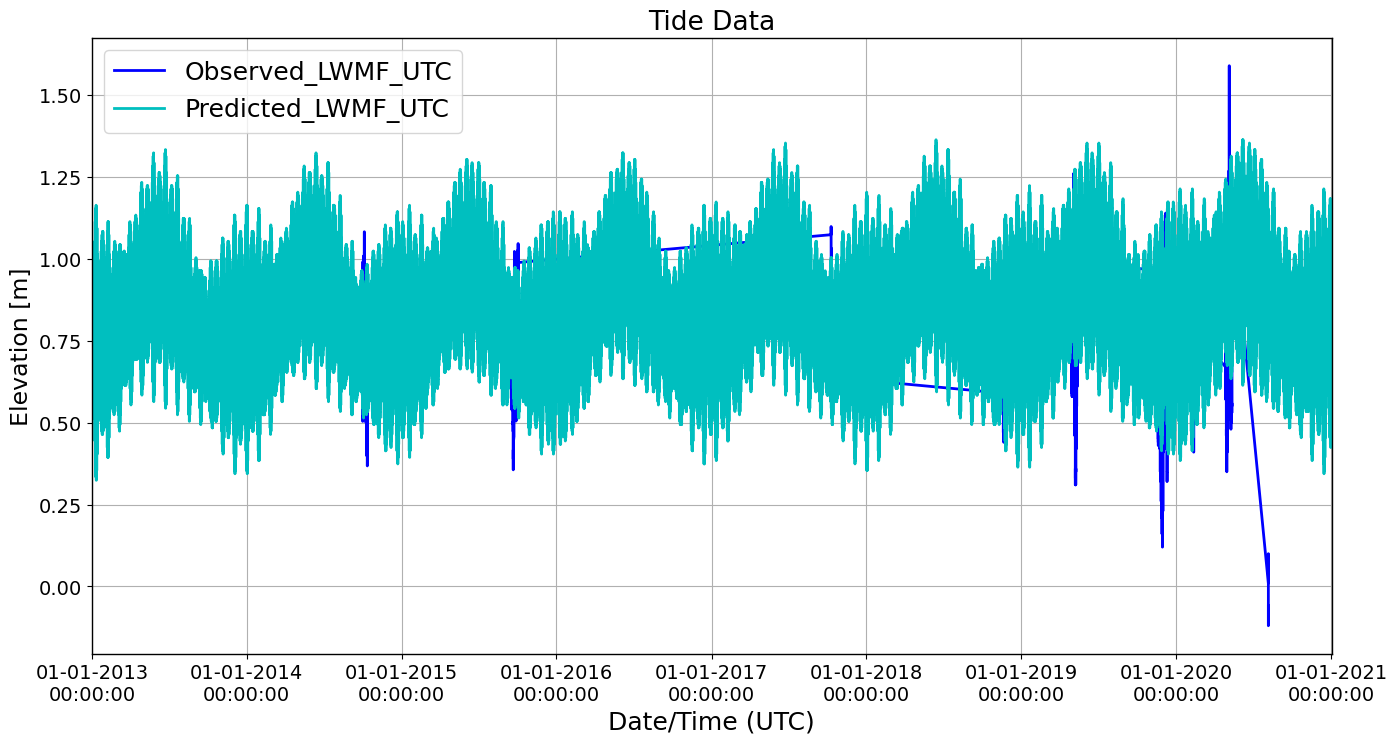

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Figs\Tide Data_2012-12-31_2021-01-02.png


In [22]:
#%% Plot Everything:
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    cut_fromStart_obj = timedelta(days=0,hours=0,minutes=0)
    cut_fromEnd_obj = timedelta(days=0,hours=0,minutes=0)
    plot_gap_obj = timedelta(days=1,hours=0,minutes=0)
    
    start_plot = start_time+cut_fromStart_obj-plot_gap_obj
    end_plot = end_time-cut_fromEnd_obj+plot_gap_obj
    
    print(start_plot)
    print(end_plot)
    
    s_time_str = (start_plot).strftime(datetimeformat2) 
    e_time_str = (end_plot).strftime(datetimeformat2) 
    
    kwargs = {
        # "start":"2021/03/10 02:37:00", # "%Y/%m/%d %H:%M:%S"
        # "end":"2021/04/5 07:20:00",
        "start":s_time_str, # "%Y-%m-%d %H:%M:%S"
        "end":e_time_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        # "waterlevel_Predicted_LWMF_UTC":"r-",
        "waterlevel_Predicted_LWMF_UTC":"c-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True
        }
    
    #plot decorations
    x_s,y_s = 16,8
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    
    
    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    fig = plt.figure(figsize=(x_s,y_s))
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    
    
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border    
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    plt.show()
    
    
    #%
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(pythonFile_dir,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(pythonFile_dir,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")

if __name__ == "__main__":
    main()

## Plot a segment of data

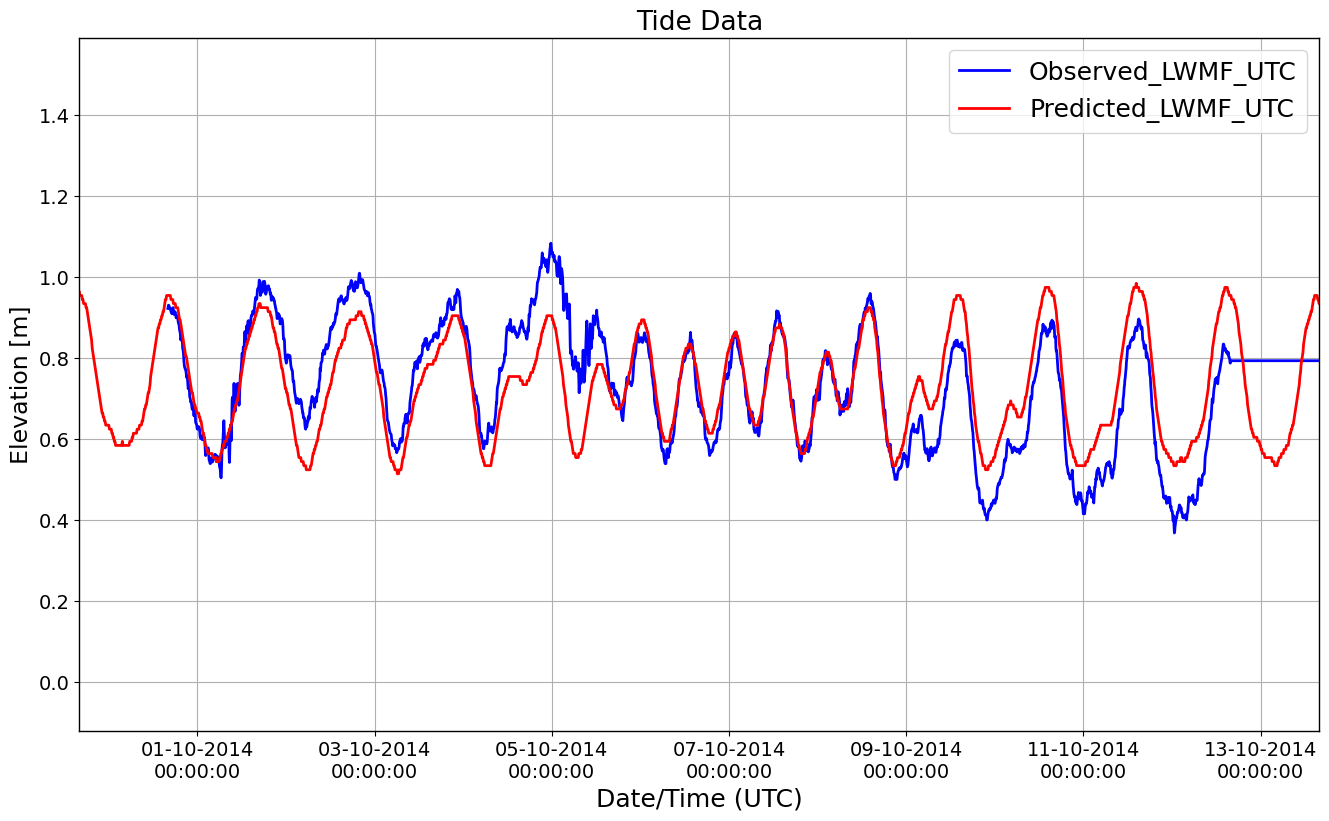

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115\Figs\Tide Data_2014-09-29_2014-10-13.png


In [23]:
#%% Custom plot
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    #define step using time delta object
    # datetime.timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
    fromStart_obj = timedelta(days=0,hours=0)
    fromEnd_obj = timedelta(days=1,hours=0)
    plot_period_obj = timedelta(days=10,hours=0)
    plot_gap_obj = timedelta(days=0,hours=5,minutes=0)
    s_time_sub_obj = start_time + fromStart_obj -plot_gap_obj
    e_time_sub_obj = s_time_sub_obj + plot_period_obj + plot_gap_obj
    m_time_sub_obj = s_time_sub_obj + (e_time_sub_obj - s_time_sub_obj)/2


    # s_time_sub_str = s_time_sub_obj.strftime(datetimeformat2)
    # e_time_sub_str = e_time_sub_obj.strftime(datetimeformat2)
    # m_time_sub_str = m_time_sub_obj.strftime(datetimeformat2)
    s_time_sub_str = "2014-09-29 16:00:00" #"%Y-%m-%d %H:%M:%S"
    e_time_sub_str = "2014-10-13 15:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2015-09-17 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2015-10-03 0:59:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2017-10-09 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2017-10-12 00:00:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2018-11-19 00:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2018-11-22 00:05:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-04-28 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-05-15 0:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-11-19 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-12-12 0:55:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2020-02-11 0:34:18" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-02-12 0:42:20" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-03-17 23:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-03-20 01:45:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-04-25 16:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-12 15:55:00" #"%Y-%m-%d %H:%M:%S"
    # 
    # s_time_sub_str = "2020-05-9 20:30:20" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-11 20:47:17" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-08-04 17:48:05" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-08-06 18:23:01" #"%Y-%m-%d %H:%M:%S"
    # m_time_sub_str = "2021-04-04 0:0:0"
    
    kwargs = {
        "start":s_time_sub_str,
        "end":e_time_sub_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        "waterlevel_Predicted_LWMF_UTC":"r-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True,
        
        }
    
    #plot decorations
    x_s,y_s = 16,9
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    fig = plt.figure(figsize=(x_s,y_s))
    

    x_lim_adjust_above = 0.0
    x_lim_adjust_below = 0.0
    

    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    

    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    
   
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    
    # start_plot = very_start
    # end_plot = very_end
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    
    # ax1.set_ylim([1.0,2.15]) set y lime based on max and min tide
    Max_tide = max(max(tide_Observed_LWMF_UTC),max(tide_Predicted_LWMF_UTC))
    Min_tide = min(min(tide_Observed_LWMF_UTC),min(tide_Predicted_LWMF_UTC))
    
    ax1.set_ylim([Min_tide+x_lim_adjust_below,Max_tide-x_lim_adjust_above])
    
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    aspect_vl = 'auto'
    # aspect_vl = 'equal'
    # aspect_vl = '0.1'
    ax1.set_aspect(aspect_vl)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    
    #Plot tide value for one spot
    
    # in_dt_str = m_time_sub_str
    # in_dt_str = min(dtime_SI1016_TG1B_LAT).strftime(datetimeformat2)
    # in_result = tide_interploate(in_dt=dtime_Predicted_LWMF_UTC,
    #                  in_tide=tide_Predicted_LWMF_UTC,
    #                  dt_YmdHMS=in_dt_str)
    # msg = f'Interpolated result for SI1016_TG1 is: {in_result} m'
    # print(msg)


    # # draw a vertical line at the check point 2do
    # plt.axvline(x=max(dtime_Observed_LWMF_UTC),
    #             color="b", 
    #             linestyle="-",
    #             linewidth=2.0)
    
    # plt.scatter(max(dtime_Observed_LWMF_UTC),tide_Observed_LWMF_UTC[-1])
    # plt.text(max(dtime_Observed_LWMF_UTC), tide_Observed_LWMF_UTC[-1], tide_Observed_LWMF_UTC[-1],
    #           fontsize=14,color='b')
    # #Plot a vertical line where interpolation take place

    plt.show()
    
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(result_day,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(result_day,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")
    

if __name__ == "__main__":
    main()

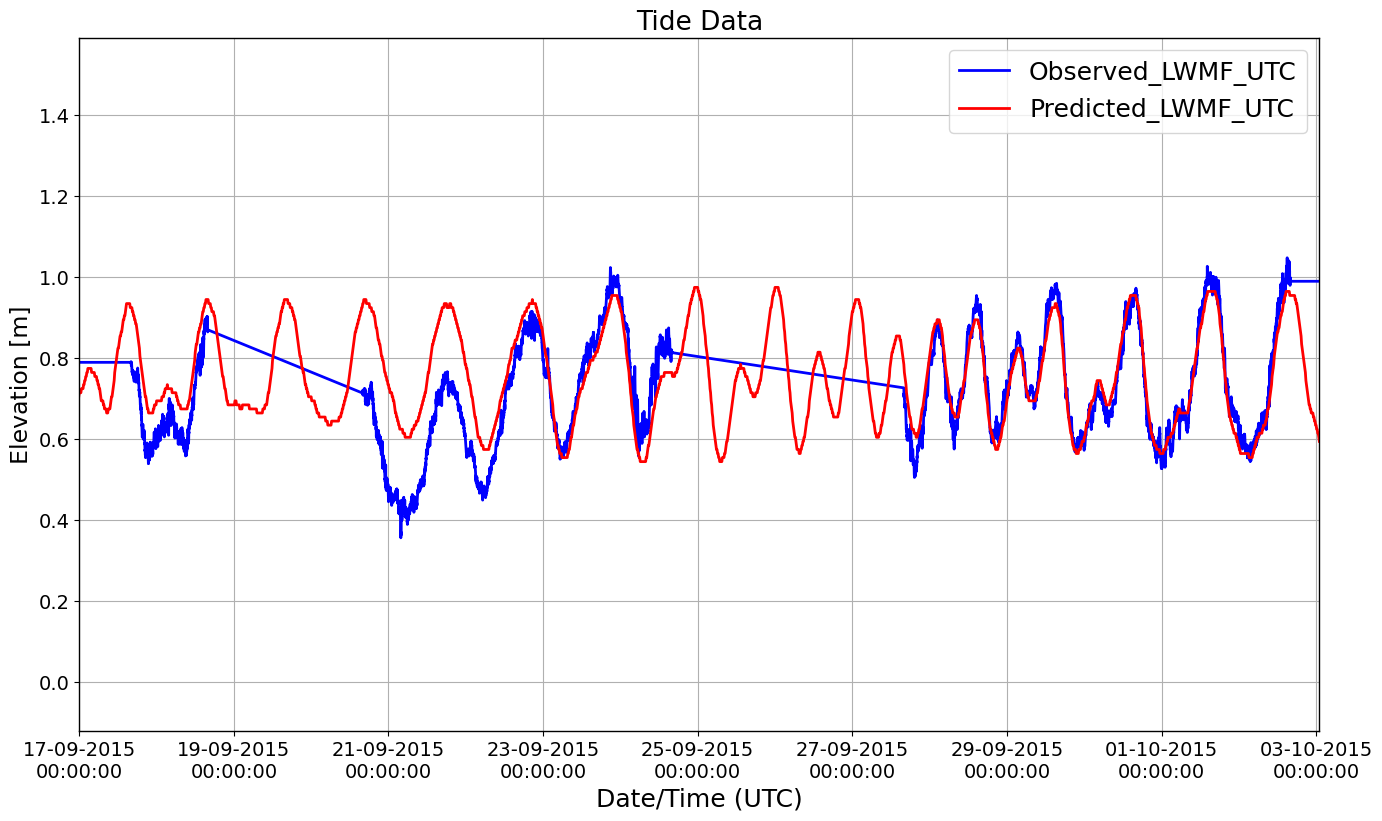

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115\Figs\Tide Data_2015-09-17_2015-10-03.png


In [24]:
#%% Custom plot
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    #define step using time delta object
    # datetime.timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
    fromStart_obj = timedelta(days=0,hours=0)
    fromEnd_obj = timedelta(days=1,hours=0)
    plot_period_obj = timedelta(days=10,hours=0)
    plot_gap_obj = timedelta(days=0,hours=5,minutes=0)
    s_time_sub_obj = start_time + fromStart_obj -plot_gap_obj
    e_time_sub_obj = s_time_sub_obj + plot_period_obj + plot_gap_obj
    m_time_sub_obj = s_time_sub_obj + (e_time_sub_obj - s_time_sub_obj)/2


    # s_time_sub_str = s_time_sub_obj.strftime(datetimeformat2)
    # e_time_sub_str = e_time_sub_obj.strftime(datetimeformat2)
    # m_time_sub_str = m_time_sub_obj.strftime(datetimeformat2)
    
#     s_time_sub_str = "2014-09-29 16:00:00" #"%Y-%m-%d %H:%M:%S"
#     e_time_sub_str = "2014-10-13 15:55:00" #"%Y-%m-%d %H:%M:%S"
    
    s_time_sub_str = "2015-09-17 0:00:00" #"%Y-%m-%d %H:%M:%S"
    e_time_sub_str = "2015-10-03 0:59:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2017-10-09 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2017-10-12 00:00:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2018-11-19 00:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2018-11-22 00:05:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-04-28 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-05-15 0:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-11-19 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-12-12 0:55:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2020-02-11 0:34:18" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-02-12 0:42:20" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-03-17 23:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-03-20 01:45:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-04-25 16:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-12 15:55:00" #"%Y-%m-%d %H:%M:%S"
    # 
    # s_time_sub_str = "2020-05-9 20:30:20" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-11 20:47:17" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-08-04 17:48:05" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-08-06 18:23:01" #"%Y-%m-%d %H:%M:%S"
    # m_time_sub_str = "2021-04-04 0:0:0"
    
    kwargs = {
        "start":s_time_sub_str,
        "end":e_time_sub_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        "waterlevel_Predicted_LWMF_UTC":"r-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True,
        
        }
    
    #plot decorations
    x_s,y_s = 16,9
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    fig = plt.figure(figsize=(x_s,y_s))
    

    x_lim_adjust_above = 0.0
    x_lim_adjust_below = 0.0
    

    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    

    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    
   
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    
    # start_plot = very_start
    # end_plot = very_end
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    
    # ax1.set_ylim([1.0,2.15]) set y lime based on max and min tide
    Max_tide = max(max(tide_Observed_LWMF_UTC),max(tide_Predicted_LWMF_UTC))
    Min_tide = min(min(tide_Observed_LWMF_UTC),min(tide_Predicted_LWMF_UTC))
    
    ax1.set_ylim([Min_tide+x_lim_adjust_below,Max_tide-x_lim_adjust_above])
    
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    aspect_vl = 'auto'
    # aspect_vl = 'equal'
    # aspect_vl = '0.1'
    ax1.set_aspect(aspect_vl)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    
    #Plot tide value for one spot
    
    # in_dt_str = m_time_sub_str
    # in_dt_str = min(dtime_SI1016_TG1B_LAT).strftime(datetimeformat2)
    # in_result = tide_interploate(in_dt=dtime_Predicted_LWMF_UTC,
    #                  in_tide=tide_Predicted_LWMF_UTC,
    #                  dt_YmdHMS=in_dt_str)
    # msg = f'Interpolated result for SI1016_TG1 is: {in_result} m'
    # print(msg)


    # # draw a vertical line at the check point 2do
    # plt.axvline(x=max(dtime_Observed_LWMF_UTC),
    #             color="b", 
    #             linestyle="-",
    #             linewidth=2.0)
    
    # plt.scatter(max(dtime_Observed_LWMF_UTC),tide_Observed_LWMF_UTC[-1])
    # plt.text(max(dtime_Observed_LWMF_UTC), tide_Observed_LWMF_UTC[-1], tide_Observed_LWMF_UTC[-1],
    #           fontsize=14,color='b')
    # #Plot a vertical line where interpolation take place

    plt.show()
    
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(result_day,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(result_day,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")
    

if __name__ == "__main__":
    main()

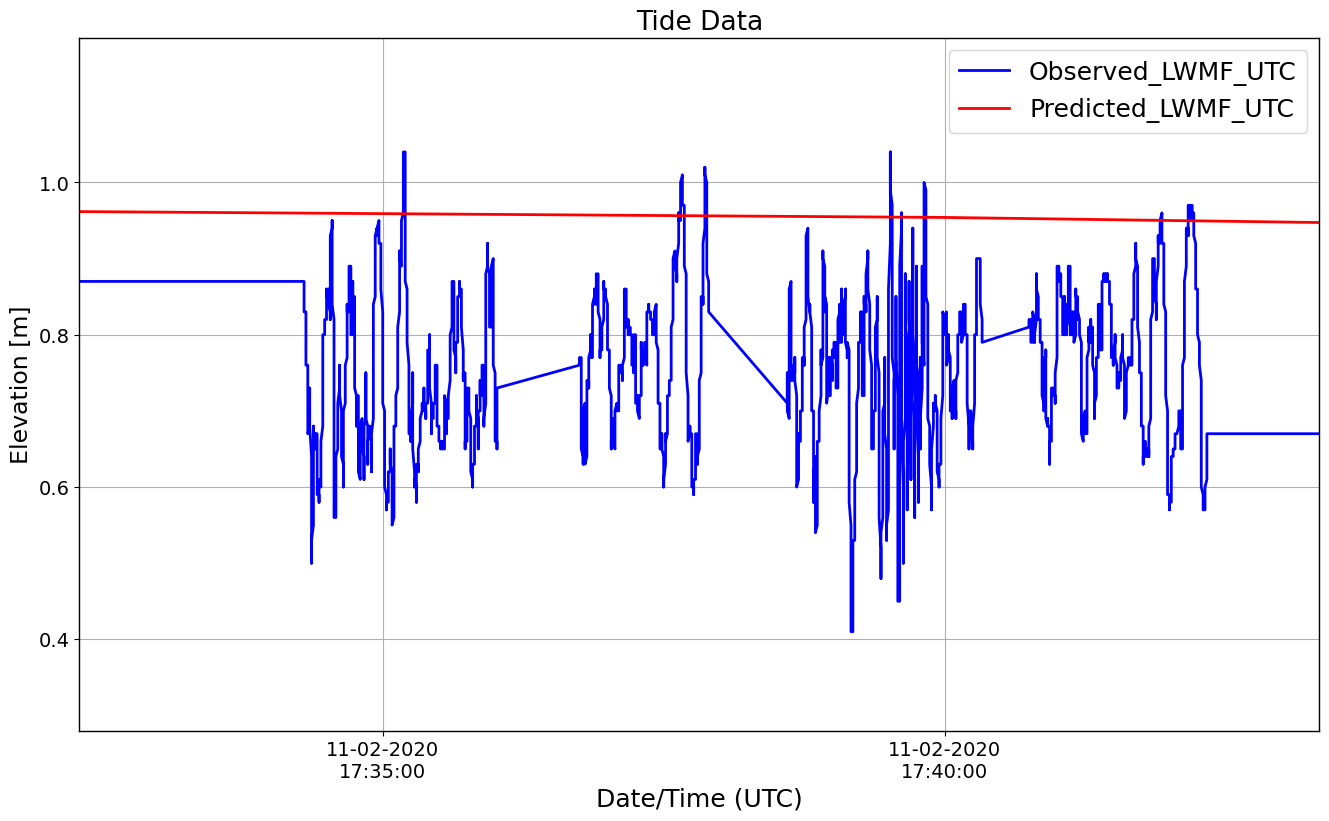

Save png file to D:\OneDrive - Curtin University of Technology Australia\write\c3_vU\Observed_Tide\All_Merged_Tide\Tide_Plot\20220115\Figs\Tide Data_2020-02-11_2020-02-11.png


In [26]:
#%% Custom plot
#set starting and ending time to plot

def main():
    datetimeformat1 = "%Y/%m/%d %H:%M:%S"
    datetimeformat2 = "%Y-%m-%d %H:%M:%S"
    
    start_time = min(min(dtime_Observed_LWMF_UTC),min(dtime_Predicted_LWMF_UTC))
    end_time = max(max(dtime_Observed_LWMF_UTC),max(dtime_Predicted_LWMF_UTC))
    
    #define step using time delta object
    # datetime.timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
    fromStart_obj = timedelta(days=0,hours=0)
    fromEnd_obj = timedelta(days=1,hours=0)
    plot_period_obj = timedelta(days=10,hours=0)
    plot_gap_obj = timedelta(days=0,hours=5,minutes=0)
    s_time_sub_obj = start_time + fromStart_obj -plot_gap_obj
    e_time_sub_obj = s_time_sub_obj + plot_period_obj + plot_gap_obj
    m_time_sub_obj = s_time_sub_obj + (e_time_sub_obj - s_time_sub_obj)/2


    # s_time_sub_str = s_time_sub_obj.strftime(datetimeformat2)
    # e_time_sub_str = e_time_sub_obj.strftime(datetimeformat2)
    # m_time_sub_str = m_time_sub_obj.strftime(datetimeformat2)
    
    # s_time_sub_str = "2014-09-29 16:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2014-10-13 15:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2015-09-17 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2015-10-03 0:59:00" #"%Y-%m-%d %H:%M:%S"

    # s_time_sub_str = "2017-10-09 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2017-10-12 00:00:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2018-11-19 00:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2018-11-22 00:05:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-04-28 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-05-15 0:55:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2019-11-19 0:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2019-12-12 0:55:00" #"%Y-%m-%d %H:%M:%S"

    s_time_sub_str = "2020-02-11 17:32:18" #"%Y-%m-%d %H:%M:%S"
    e_time_sub_str = "2020-02-11 17:43:20" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-03-17 23:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-03-20 01:45:00" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-04-25 16:00:00" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-12 15:55:00" #"%Y-%m-%d %H:%M:%S"
    # 
    # s_time_sub_str = "2020-05-9 20:30:20" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-05-11 20:47:17" #"%Y-%m-%d %H:%M:%S"
    
    # s_time_sub_str = "2020-08-04 17:48:05" #"%Y-%m-%d %H:%M:%S"
    # e_time_sub_str = "2020-08-06 18:23:01" #"%Y-%m-%d %H:%M:%S"
    # m_time_sub_str = "2021-04-04 0:0:0"
    
    kwargs = {
        "start":s_time_sub_str,
        "end":e_time_sub_str,
        "waterlevel_Observed_LWMF_UTC":"b-",
        "waterlevel_Predicted_LWMF_UTC":"r-",
        # "waterlevel_SI1016_TG3A_LAT":"c-",
        # "waterlevel_SI1016_TG4A_LAT":"m--",
        # "waterlevel_SI1016_TG5A_LAT":"y-.",
        # "waterlevel_SI1016_TG6A_LAT":"k--",
        # "waterlevel_SI1016_TG7A_LAT":"g-.",
        # "residual":"y",
        "save":True,
        # "kml":True,
        
        }
    
    #plot decorations
    x_s,y_s = 16,9
    legend_s,axis_s, title_s,tick_s = 18,18,19,14
    x_tik_r,y_tik_r = 0,0
    x_label = "Date/Time (UTC)"
    fig = plt.figure(figsize=(x_s,y_s))
    

    x_lim_adjust_above = 0.4
    x_lim_adjust_below = 0.4
    

    #start indexing and finish indexing of the data to be plotted
    
    # ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(min(dtime_Observed_LWMF_UTC)) #for plotting only one gauge
    # ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Observed_LWMF_UTC = dtime_Observed_LWMF_UTC.index(max(dtime_Observed_LWMF_UTC))  #for plotting only one gauge
    

    # ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["start"],datetimeformat2))
    ss_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(min(dtime_Predicted_LWMF_UTC))
    
    # ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(datetime.strptime(kwargs["end"],datetimeformat2))
    ff_Predicted_LWMF_UTC = dtime_Predicted_LWMF_UTC.index(max(dtime_Predicted_LWMF_UTC))
    
    
   
    
    # if "waterlevel_Observed_LWMF_UTC" in kwargs or "waterlevel_SI1016_TG1B_LAT" in kwargs:
    ax1 = fig.add_subplot(111)
    
    ax1.set_ylabel("Elevation [m]",fontsize=axis_s-1)
    ax1.grid(True)
    
    plines = []
    
    
    if "waterlevel_Observed_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],tide_Observed_LWMF_UTC[ss_Observed_LWMF_UTC:ff_Observed_LWMF_UTC],
                            kwargs["waterlevel_Observed_LWMF_UTC"],
                            label="Observed_LWMF_UTC",linewidth=2)
    
    
       
    
    if "waterlevel_Predicted_LWMF_UTC" in kwargs:
        plines += ax1.plot(dtime_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],tide_Predicted_LWMF_UTC[ss_Predicted_LWMF_UTC:ff_Predicted_LWMF_UTC],
                            kwargs["waterlevel_Predicted_LWMF_UTC"],
                            label="Predicted_LWMF_UTC",linewidth=2)
        
    labels = [l.get_label() for l in plines]
    plt.legend(plines,labels,fontsize=legend_s)
    plt.title(gauge_info['Site'],fontsize=title_s)
    # ax1.set_title(gauge_info['Site'],fontsize=title_s, fontweight='bold')
    
    
    # start_plot = very_start
    # end_plot = very_end
    
    start_plot = datetime.strptime(kwargs["start"],datetimeformat2)
    end_plot = datetime.strptime(kwargs["end"],datetimeformat2)
    
    # ax1.set_xlim([dtime_SI1016_TG1B_LAT[ss_SI1016_TG1B_LAT],dtime_SI1016_TG1B_LAT[ff_SI1016_TG1B_LAT]])
    ax1.set_xlim([start_plot,end_plot])
    
    # ax1.set_ylim([1.0,2.15]) set y lime based on max and min tide
    Max_tide = max(max(tide_Observed_LWMF_UTC),max(tide_Predicted_LWMF_UTC))
    Min_tide = min(min(tide_Observed_LWMF_UTC),min(tide_Predicted_LWMF_UTC))
    
    ax1.set_ylim([Min_tide+x_lim_adjust_below,Max_tide-x_lim_adjust_above])
    
    ax1.set_xlabel(x_label,fontsize=axis_s)
    # plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d-%m-%Y\n%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    aspect_vl = 'auto'
    # aspect_vl = 'equal'
    # aspect_vl = '0.1'
    ax1.set_aspect(aspect_vl)
    mpl.rcParams['axes.linewidth'] = 1 #set the thicnkess of border
    plt.xticks(rotation=x_tik_r,fontsize=tick_s)
    plt.yticks(rotation=y_tik_r,fontsize=tick_s)
    
    #Plot tide value for one spot
    
    # in_dt_str = m_time_sub_str
    # in_dt_str = min(dtime_SI1016_TG1B_LAT).strftime(datetimeformat2)
    # in_result = tide_interploate(in_dt=dtime_Predicted_LWMF_UTC,
    #                  in_tide=tide_Predicted_LWMF_UTC,
    #                  dt_YmdHMS=in_dt_str)
    # msg = f'Interpolated result for SI1016_TG1 is: {in_result} m'
    # print(msg)


    # # draw a vertical line at the check point 2do
    # plt.axvline(x=max(dtime_Observed_LWMF_UTC),
    #             color="b", 
    #             linestyle="-",
    #             linewidth=2.0)
    
    # plt.scatter(max(dtime_Observed_LWMF_UTC),tide_Observed_LWMF_UTC[-1])
    # plt.text(max(dtime_Observed_LWMF_UTC), tide_Observed_LWMF_UTC[-1], tide_Observed_LWMF_UTC[-1],
    #           fontsize=14,color='b')
    # #Plot a vertical line where interpolation take place

    plt.show()
    
    
    datestamp = datetime.strftime(dtime_Observed_LWMF_UTC[ss_Observed_LWMF_UTC],"%Y%m%d%H")
    date_start_str = kwargs['start'][:10].replace('/','')
    date_end_str = kwargs['end'][:10].replace('/','')
    if "save" in kwargs:
        if kwargs['save']:
            fig_fldr = os.path.join(result_day,'Figs')
            # fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png")
            fignam = os.path.join(fig_fldr,gauge_info['Site'].split(",")[0] + "_" + date_start_str+'_'+date_end_str+ ".png")
            if not os.path.exists(fig_fldr):
                os.mkdir(fig_fldr)    
            fig.savefig(fignam, dpi=fig.dpi)
            os.chdir(fig_fldr)
            figpath = os.getcwd() + "\\"
            os.chdir(pydir)
            figabspath = figpath + gauge_info['Site'].split(",")[0] + "_" + datestamp + ".png"
            print(f'Save png file to {fignam}')
    plt.close()
    
    if "save" in kwargs and "kml" in kwargs:
        if kwargs['kml'] and kwargs['save']:
            kml_fldr = os.path.join(result_day,'kml')
            if not os.path.exists(kml_fldr):
                os.mkdir(kml_fldr)
            kmlnam = kml_fldr + '\\' + os.path.basename(fignam[:-4].split("/")[-1] + ".kml")
            fkml = open(kmlnam,'w')
            print("Writing kml file to %s" % kmlnam)            
            fkml.write(kmlTemplate() % (gauge_info["Site"],gauge_info["Site"],figabspath,gauge_info['Longitude'],gauge_info['Latitude']))
            fkml.close()
        elif kwargs['kml'] and not kwargs['save']:
            print("In the figure options 'save' must be set to True to create kml.")
    elif "kml" in kwargs and kwargs['kml'] and not "save" in kwargs:
        print("The option 'save' needs to be in kwargs and set to True to produce a kml.")
    

if __name__ == "__main__":
    main()
    
